# 2.1.2 Directed search: Generating alternatives

In this file the MOEA optimization algorithm is used to search through the lever space of the model in order to find promising policies (candidate strategies) to reach the defined objectives. The objectives are defined in problem_formulation.py and all aim to minimize the specified outcomes. The reference scenario is defined based on the open exploration and represents a "worst-case" scenario. This scenario, model initialisation, and data generation is done in the dike_model_optimization.py file.

The model simulation uses the $\epsilon$-NSGA2 algorithm and 10000 nfes. The epsilons are set to a list of length equal to the number of outcomes: *[1e3] * len(model.outcomes)*. The convergence of the model is tracked with epsilon progress.

This notebook has the following structure:
1. Importing generated model files
2. Assessing convergence of the algorithm
3. Parallel coordinate plot of original results
4. Filtering results for policies of interest
5. Parallel coordinate plot of policies of interest

**nog uitleggen wat het reference scenario dan is? Ook uitleggen dat platypus is gebruikt? Aanvullen van gebruik van pareto?
Structuur van notebook aangeven**

Determining worst case scenario:
The coding below has been used to create a worst case scenario. The uncertainty values of this worst case scenario will be used as reference case in the further steps of the MORDM. The worst case scenario has been defined as the scenario with the highest amount of expected deaths and highest expected annual damage.

In [ ]:
#Importing worst case scenarios
experiments = pd.read_csv('data/output_data/experiments_2000s_0p.csv')
outcomes = pd.read_csv('data/output_data/outcomes_2000s_0p.csv')

experiments = experiments.drop(columns='Unnamed: 0')
outcomes = outcomes.drop(columns='Unnamed: 0')

In [ ]:
# As a first step, the scenarios that belong to the worst 10% of both objectives are selected
select_worst_outcomes = outcomes[(outcomes['Expected Annual Damage']  > np.percentile(outcomes['Expected Annual Damage'],90)) & (outcomes['Expected Number of Deaths']  > np.percentile(outcomes['Expected Number of Deaths'],90))]
select_worst_outcomes

In [ ]:
# We want to know which values of the uncertainties belongs to the worst case scenario. Therefore, we again use only the uncertainty columns of the experiments.
uncertainty_experiments

In [ ]:
# In order to match the outcomes with their uncertainty values the uncertainty columns are merged with the selected worst case outcomes
merged_columns = pd.merge(select_worst_outcomes , uncertainty_experiments , left_index=True, right_index=True)
merged_columns

In [ ]:
# For the reference case the mean values of these uncertainties are taken. The values are printed below
uncertainty_col_merged = merged_columns.loc[:,list_of_uncertainties]
uncertainty_col_merged.mean(axis=0)

In [ ]:
# Since the value of the A.0_ID flood wave shape is ???, it is chosen to use the value of the scenario in which both the expected number of deaths as well as the expected annual damage are maximized
# Scenario 19230 is selected; 84 will be taken as worst case value
merged_columns.sort_values(by=['Expected Number of Deaths','Expected Annual Damage'],ascending =False)

Importing MOEA information

In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant, SequentialEvaluator)
from ema_workbench.analysis import parcoords

In [14]:
# Import the dike_model
from problem_formulation import get_model_for_problem_formulation

# Define model
dike_model, planning_steps = get_model_for_problem_formulation(2)

### 1. Importing generated model files
The csv files that were created in dike_model_optimization.py are imported and shortly explored.

UITLEGGEN WAT DIKE_MODEL_OPTIMIZATION DOET!!!! WAT VOOR SOORT RUN IS DAT? EEN VORM VAN OPTIMALISEREN OVER UNCERTAINTIES

In [15]:
# Import CSV files generated in dike_model_optimization
results = pd.read_csv('data/output_data/results_optimization_10000nfe.csv')
convergence = pd.read_csv('data/output_data/convergence_optimization_10000nfe.csv')

In [16]:
# Print results
results

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,0,0,0,0,0,0,0,0,1,0,...,1,2,7,0,0,0.000000e+00,2.272627e+08,30700000.0,0.000000,0.000000
1,1,0,1,0,0,0,0,1,1,0,...,6,0,4,0,0,6.942334e+07,7.633835e+07,146000000.0,1450.062933,0.022336
2,2,0,0,0,0,0,0,0,1,0,...,3,0,4,0,0,1.007819e+08,1.142095e+08,30700000.0,2837.103641,0.035400
3,3,0,0,0,0,0,0,0,1,0,...,1,0,6,0,1,9.393269e+06,2.165385e+08,30700000.0,430.231765,0.001465
4,4,0,1,1,0,0,0,0,1,0,...,0,3,5,0,0,9.393269e+06,1.678554e+08,199900000.0,430.231765,0.001465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,176,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1.196824e+08,6.992287e+07,0.0,0.000000,0.133537
177,177,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,5.843894e+07,3.901570e+07,357700000.0,0.000000,0.057275
178,178,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1.209124e+08,6.320800e+06,267200000.0,2927.609462,0.047621
179,179,0,1,1,0,0,0,1,1,0,...,0,0,3,0,0,4.752965e+07,6.171959e+07,230600000.0,0.000000,0.046780


The *results* dataframe includes 181 rows and 37 columns. This indicates that there are 181 strategies, combinations of levers, found that are pareto optimal conditional on the defined reference scenario. Each of these strategies have their own tradeoffs. This will later be explored with a parallel coordinate plot.

In [17]:
# Print convergence
convergence

,Unnamed: 0,epsilon_progress,nfe
0,0,0,0
1,1,29,100
2,2,229,1196
3,3,426,2288
4,4,619,3386
5,5,757,4483
6,6,845,5582
7,7,944,6677
8,8,1035,7770
9,9,1086,8863


The *convergence* dataframe includes the epsilon progress on 9 generations. This information can be used to check if the MOEA has converged to the optimum solutions.

**check what the 9 different entries mean**

### 2. Convergence of the algorithm

The convergence of the algorithm can be evaluated with multiple convergence metrics. In this notebook only the epsilon progress is used. The epsilon progress indicates how often a solution in a new grid cell is found, this should stabilize as the algorithm converges.
The epsilon_progress of the algorithm run with 10000 NFEs is shown below.



**checken volledige reden waarom hypervolume niet is gebruikt ; complexity in archivelogger, makes it difficult to calculate hypervolume, generational difference and additive epsilon-indicatior. **

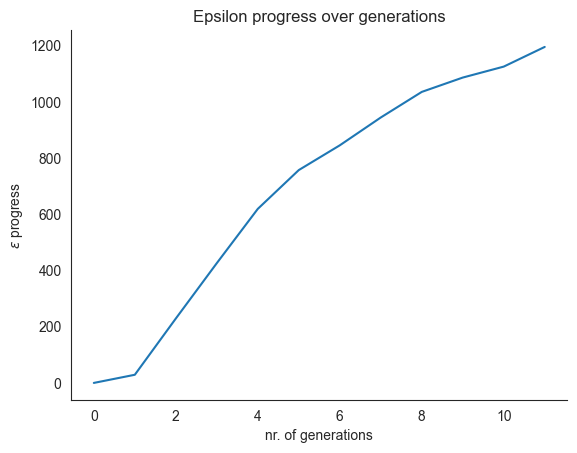

In [18]:
# Make a plot of the epsilon progress
fig, ax = plt.subplots(ncols=1)

ax.plot(convergence.epsilon_progress)
ax.set_xlabel("nr. of generations")
ax.set_ylabel(r"$\epsilon$ progress")
ax.set_title("Epsilon progress over generations")

sns.despine()
plt.show()

Visualising the epsilon progress over generations indicates that the algorithm has not yet stabilized. This indicates that the number of function evaluations (NFEs) has not been sufficient. Due to time constraints it has been chosen not to increase the number of NFEs and see the minimal convergence as a limitation.

**evt laten runnen met nog meer nfe, dan wel convergence? Daarnaast: toepassen van multiple seeds: the role of stochasticy**

- MOEAs use stochastics in crossover and mutation. Thus, the specific set of results will vary from one run of the algorithm to the next. Analogous to how you deal with stochasticitiy in discrete event models, it is best practice to run an MOEA multiple times using a different random seed. Next, you would combine the results from the different runs into a combined pareto approximate set.

Geen hypervolume omdat dan directe constraints aangeven. Weten niet precies wat dit dan moet zijn en zet harde constraints op het model.


### 3. Parallel coordinate plot
Parallel coordinate plots show the tradeoffs of the 181 solutions that were found by the algorithm.

In [1]:
# Get objectives from results dataframe
data = results.loc[:, [o.name for o in dike_model.outcomes]]

# Define limits based on results dataframe
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Expected Number of Deaths',
               'Dike Investment Costs', 'RfR Investment Costs',
               'Evacuation Costs']] = 0

# Set axes of parallel cooridinate plots
paraxes = parcoords.ParallelAxes(limits)

# Plot data on axis
paraxes.plot(data)

# Set title
plt.title("Multi-Objective Parallel Coordinate Plot")
plt.show()

NameError: name 'results' is not defined

Plotting all 181 solutions results in a cluttered visualisation of the tradeoffs. It can be seen that pareto outcomes are found within different ranges. These ranges can be limited in order to come to a filtered set of solutions.

### 4. Filtering results to outcomes of interest
The outcomes of interest that are found by the MOEA algorithm significant ranges. More insight in these ranges can be created by looking into the descriptives of the objectives.

In [20]:
data = results.loc[:, [o.name for o in dike_model.outcomes]]
data.describe()

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
count,1.810000e+02,1.810000e+02,1.810000e+02,181.000000,181.000000
mean,1.783748e+08,7.207747e+07,2.352901e+08,2250.508265,0.104145
std,3.693218e+08,5.797841e+07,2.411891e+08,4145.475691,0.236285
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,2.418356e+07,2.763137e+07,3.070000e+07,0.000000,0.008416
50%,6.942334e+07,5.638374e+07,1.692000e+08,367.545556,0.025133
75%,1.244619e+08,1.142095e+08,3.518000e+08,2838.903166,0.078750
max,1.760190e+09,2.298248e+08,1.270300e+09,23595.358339,1.323968


As the most important goals is to minimize casualties, policies with less than 0.001 expected number of deaths are taken into consideration. Furthermore, the summation of RfR investment costs, Dike Investment Costs, and Evacuation costs are limited to 530 million euros.

The investment limitation is based on the total budget/spending on the Room for the River project. [Rijkswaterstaat](https://www.rijkswaterstaat.nl/water/waterbeheer/bescherming-tegen-het-water/maatregelen-om-overstromingen-te-voorkomen/ruimte-voor-de-rivieren#maatregelen) states that the total budget was 2.3 billion euros, divided over 39 different measures. Nine measures were excecuted on the IJssel river, resulting in an assumption of allocated budget of 530 million euros for the RfR investment costs.


In [21]:
# Add a new column to calculate total investment costs
results["Total Costs"] = results['Dike Investment Costs']+results['RfR Investment Costs']+results['Evacuation Costs']

In [22]:
selected_results = results[(results['Expected Number of Deaths']  < 0.001) & (results['Total Costs'] < 530e6)]
selected_results

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Costs
0,0,0,0,0,0,0,0,0,1,0,...,2,7,0,0,0.000000e+00,2.272627e+08,30700000.0,0.000000,0.000000,2.579627e+08
10,10,0,1,0,0,0,0,0,0,0,...,0,3,0,0,4.942016e+06,1.750928e+08,205800000.0,342.779096,0.000347,3.808931e+08
15,15,0,0,0,0,0,0,0,0,1,...,0,5,0,0,9.791734e+06,1.910145e+08,30700000.0,677.398829,0.000690,2.217152e+08
45,45,1,1,0,0,0,0,0,0,1,...,0,3,1,0,4.430914e+06,1.781426e+08,321100000.0,196.062980,0.000953,4.992428e+08
63,63,0,1,0,0,0,0,1,0,0,...,0,7,0,0,0.000000e+00,1.848850e+08,115300000.0,0.000000,0.000000,3.001850e+08
95,95,0,0,0,0,0,0,0,0,0,...,0,7,0,0,0.000000e+00,2.298248e+08,0.0,0.000000,0.000000,2.298248e+08
116,116,1,1,0,0,0,0,1,1,0,...,1,4,0,0,0.000000e+00,1.300643e+08,351800000.0,0.000000,0.000000,4.818643e+08
139,139,0,0,0,0,0,0,1,1,0,...,2,7,0,0,7.989784e+06,1.837231e+08,61400000.0,535.308649,0.000642,2.451236e+08
153,153,0,1,1,0,0,0,1,0,1,...,0,4,0,0,4.379502e+06,1.252766e+08,351800000.0,195.745393,0.000926,4.770768e+08


The selection results in 9 different policies. The tradeoffs in these policies can be evaluated with a parallel coordinates plot.

### 5. Parallel coordinate plot of policies of interest

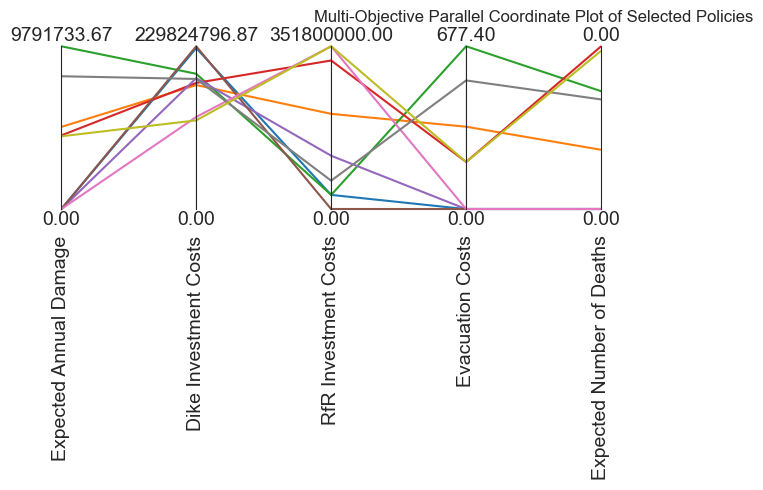

In [23]:
# Get objectives from results dataframe
data = selected_results.loc[:, [o.name for o in dike_model.outcomes]]

# Define limits based on results dataframe
limits = parcoords.get_limits(data)
limits.loc[0, ['Expected Annual Damage', 'Expected Number of Deaths',
               'Dike Investment Costs', 'RfR Investment Costs',
               'Evacuation Costs']] = 0

# Set axes of parallel cooridinate plots
paraxes = parcoords.ParallelAxes(limits)

# Plot data on axis
paraxes.plot(data)

# Set title
plt.title("Multi-Objective Parallel Coordinate Plot of Selected Policies")
plt.show()

The parallel coordinate plot indicates that there are still large trade-offs between the objectives. A first look indicates that it is possible to minimize expected annual damage, evacuation costs and expected number of deaths, but this comes at higher investment costs.

**full description of the defined policies should be added to appendix**

The policies found in the dataframe selected_results are saved to a CSV file.

In [27]:
policies = selected_results.drop(['Expected Annual Damage',
                                  'Dike Investment Costs',
                                  'RfR Investment Costs',
                                  'Evacuation Costs',
                                  'Expected Number of Deaths',
                                  'Total Costs', 'Unnamed: 0'], axis=1)

policies.to_csv('data/output_data/policies.csv')

### Next steps
The selected policies are evaluated under 5000 scenarios in the dike_model_optimization.py. The resulting csv files are evaluated in MORDM_3_uncertainty_analysis.